<h1 align='center'>Denver Crime Report (2014-Present)</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from IPython.display import Markdown as md
import seaborn as sns
%matplotlib inline

## Section 1: Dataset Description and Exploratory Analysis

Read in the data from the csv url and `denver_offense_codes.csv`.

In [2]:
url = 'https://www.denvergov.org/media/gis/DataCatalog/crime/csv/crime.csv'
df1 = pd.read_csv(url)
df2 = pd.read_csv('denver_offense_codes.csv')

These dataframes can easily be merged by columns, the second dataset `df2` is essentially a 'key' for `df1`. The reasoning behind doing this is because `df2` contains more grammatically correct values/entries for the crime categories/types.

In [3]:
df = df1.merge(df2)

In [4]:
rows, columns = df.shape
md("There is now a dataframe, `df`, containing %i rows and %i columns of data - that's %i datapoints!"%(rows, columns, rows*columns))

There is now a dataframe, `df`, containing 515809 rows and 21 columns of data - that's 10831989 datapoints!

### Dataset Description
The dataset `df` contains information about criminal and traffic incidents taking place in the city and county of Denver, CO reported to the police in the time frame 1/2/2014 - present.

A general description of each column follows:
- `INCIDENT_ID`: identifier for an incident of an offense or multiple offenses (root of `OFFENSE ID`)
- `OFFENSE_ID`: identifier for a singular offense from an incident
- `OFFENSE_CODE`: codified value for particular `OFFENSE_TYPE_ID`, `OFFENSE_CATEGORY_ID`, `OFFENSE_TYPE_NAME`, and `OFFENSE_CATEGORY_NAME` (primarily serves as part of the key between `df1` and `df2` above)
- `OFFENSE_CODE_EXTENSION`: extension to `OFFENSE_CODE`, serves similar purpose
- `OFFENSE_TYPE_ID`: a descriptive name for type of offense committed, more specific than `OFFENSE_CATEGORY_ID` (in dash separated format - 'stolen-property-possession`)
- `OFFENSE_CATEGORY_ID`: a more general categorical name for the type of offense committed (dash separated format)
- `FIRST_OCCURRENCE_DATE`: the date and time the incident first occurred
- `LAST_OCCURRENCE_DATE`: the date and time the incident ended
- `REPORTED_DATE`: the date and time the incident was reported
- `INCIDENT_ADDRESS`: the street address where the incident took place (if applicable)
- `GEO_X`: the 'easting' value of the location of an incident in the Colorado Central (C-0502) zone of the State Plane Coordinate System (SPS)
- `GEO_Y`: the 'northing' value of the location of an incident in the Colorado Central (C-0502) zone of the State Plane Coordinate System (SPS)
- `GEO_LON`: the longitude location of the incident
- `GEO_LAT`: the latitude location of the incident
- `DISTRICT_ID`: police districts for the city of Denver, sectioning of the districts can be seen [here](https://www.denvergov.org/content/denvergov/en/police-department/police-stations.html)
- `PRECINCT_ID`: police precincts for the city of Denver, sectioning of the precincts can be seen [here](https://www.denvergov.org/content/dam/denvergov/Portals/720/documents/maps/Citywide_Map.pdf)
- `NEIGHBORHOOD_ID`: the name of the neighborhood in dash format
- `IS_CRIME`: if offense is criminal this value is 1, otherwise 0
- `IS_TRAFFIC`: if offense is traffic related this value is 1, otherwise 0
- `OFFENSE_TYPE_NAME`: a descriptive name for type of offense committed, more specific than `OFFENSE_CATEGORY_NAME` (in normal phrase format - 'Possession of stolen property')
- `OFFENSE_CATEGORY_NAME`: a more general categorical name for the type of offense committed (normal phrase format)

The source for the dataset, as well as additional documentation, can be found at the [Denver Open Data Catalog](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-crime).

More specific definitions of the types/categories of crime can be found [here](https://www.denvergov.org/media/gis/DataCatalog/crime/pdf/NIBRS_Crime_Types.pdf).

### Dataset Manipulation

There are a number of things that need altered with this dataset before hopping into further exploration.
1. Eliminate redundant and primarily null columns
2. Convert column data types to appropriate types
3. Remove all entries up to 30 days prior to the last
4. Add some additional columns based on the `FIRST_OCCURRENCE_DATE` value and `REPORTED_DATE` value

#### 1. Eliminate redundant and primarily null columns
Redundant columns include: `OFFENSE_CODE`, `OFFENSE_CODE_EXTENSION`, `OFFENSE_TYPE_ID`, `OFFENSE_CATEGORY_ID`, `GEO_X` and `GEO_Y`.

In [5]:
df.drop(['OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION', 'OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID', 'GEO_X', 'GEO_Y'], axis=1, inplace=True)

In [6]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515809 entries, 0 to 515808
Data columns (total 15 columns):
INCIDENT_ID              515809 non-null int64
OFFENSE_ID               515809 non-null int64
FIRST_OCCURRENCE_DATE    515809 non-null object
LAST_OCCURRENCE_DATE     163336 non-null object
REPORTED_DATE            515809 non-null object
INCIDENT_ADDRESS         465399 non-null object
GEO_LON                  511544 non-null float64
GEO_LAT                  511544 non-null float64
DISTRICT_ID              515809 non-null int64
PRECINCT_ID              515809 non-null int64
NEIGHBORHOOD_ID          515809 non-null object
IS_CRIME                 515809 non-null int64
IS_TRAFFIC               515809 non-null int64
OFFENSE_TYPE_NAME        515809 non-null object
OFFENSE_CATEGORY_NAME    515809 non-null object
dtypes: float64(2), int64(6), object(7)
memory usage: 188.9 MB


In [7]:
lnull = df.LAST_OCCURRENCE_DATE.isnull().sum()
length = len(df)
print('The LAST_OCCURRENCE_DATE column has {} null datapoints out of {}. That means {}% of the column is empty!'.format(lnull, length, round(lnull/length*100, ndigits=2))) 

The LAST_OCCURRENCE_DATE column has 352473 null datapoints out of 515809. That means 68.33% of the column is empty!


Delete the `LAST_OCCURRENCE_DATE` column.

In [8]:
df.drop('LAST_OCCURRENCE_DATE', axis=1, inplace=True)

#### 2. Convert column data types to appropriate types

Convert relevant columns to datetime so they can be sorted, filtered, etc.

In [9]:
df.loc[:, 'FIRST_OCCURRENCE_DATE'] = pd.to_datetime(df.loc[:, 'FIRST_OCCURRENCE_DATE'], format="%m/%d/%Y %I:%M:%S %p")
df.loc[:, 'REPORTED_DATE'] = pd.to_datetime(df.loc[:, 'REPORTED_DATE'], format="%m/%d/%Y %I:%M:%S %p")

Convert `OFFENSE_CATEGORY_NAME` and `DISTRICT_ID` to category data type to conserve memory.

In [10]:
df.loc[:, 'OFFENSE_CATEGORY_NAME'] = df.OFFENSE_CATEGORY_NAME.astype('category')
df.loc[:, 'DISTRICT_ID'] = df.DISTRICT_ID.astype('category')

Convert `IS_CRIME` and `IS_TRAFFIC` to boolean values in order to conserve memory as well.

In [11]:
bool_cols = ['IS_CRIME', 'IS_TRAFFIC']
df.loc[:, bool_cols] = df.loc[:, bool_cols].astype(bool)

#### 3. Remove all entries up to 30 days prior to the last

The reasoning behind this is in the documentation for the dataset. Since the data is changing on a consistent weekday basis, crimes reported closer to the time the dataset was updated is not yet accurate. It is recommended to go back at least 30 days from the updated date for accurate data. I will go back 30 days from the latest incident date to be more conservative.

Find the latest occurrence date, put it in `latest_date`, subtract 30 days from that date to get the latest accurate date and assign it to `acc_date`.

In [12]:
latest_date = df.FIRST_OCCURRENCE_DATE.max()
acc_date = latest_date - pd.Timedelta(30, unit='d')

In [13]:
print('The latest accurate date is {}'.format(acc_date))

The latest accurate date is 2019-08-25 04:00:00


Eliminate all rows that occur post-`acc_date`.

In [14]:
df = df[df.FIRST_OCCURRENCE_DATE < acc_date]

#### 4. Add some additional columns based on the `FIRST_OCCURRENCE_DATE` value and `REPORTED_DATE` value

In [15]:
def df_extractdt_col(col_name):
    sc = str(col_name)
    df.loc[:, sc+'_Y'] = df.loc[:, col_name].dt.year
    df.loc[:, sc+'_M'] = df.loc[:, col_name].dt.month
    df.loc[:, sc+'_D'] = df.loc[:, col_name].dt.day
    df.loc[:, sc+'_DOY'] = df.loc[:, col_name].dt.dayofyear
    df.loc[:, sc+'_DOW'] = df.loc[:, col_name].dt.dayofweek
    df.loc[:, sc+'_DOW_N'] = df.loc[:, col_name].dt.day_name()
    df.loc[:, sc+'_M_N'] = df.loc[:, col_name].dt.month_name()

In [16]:
df_extractdt_col('FIRST_OCCURRENCE_DATE')

In [17]:
df_extractdt_col('REPORTED_DATE')

A total of 14 new columns have been introduced containing information based on the datetime columns (e.g. column titled `FIRST_OCCURRENCE_DATE_D` represents the day of the month that an offense took place).
- Y is year
- M is month
- D is day of month
- DOY is day of year
- DOW is day of week
- DOW_N is day of week name
- M_N is the month name

It may be useful to compare the reported date to the first occurrence date as well, the difference will be calculated in another column, `DATE_DIFF`.

In [18]:
df.loc[:, 'DATE_DIFF'] = df.loc[:, 'REPORTED_DATE'] - df.loc[:, 'FIRST_OCCURRENCE_DATE']

Change `DOW_N` and `M_N` values to ordered category types - to simplify ordering/sorting later on.

In [19]:
def cat_convert(col):
    df.loc[:, col] = df.loc[:, col].astype('category')
def cat_order(col, how):
    df.loc[:, col].cat.reorder_categories(how, inplace=True)

In [20]:
d_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
m_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

cat_convert('FIRST_OCCURRENCE_DATE_DOW_N')
cat_order('FIRST_OCCURRENCE_DATE_DOW_N', d_order)
cat_convert('FIRST_OCCURRENCE_DATE_M_N')
cat_order('FIRST_OCCURRENCE_DATE_M_N', m_order)
cat_convert('REPORTED_DATE_DOW_N')
cat_order('REPORTED_DATE_DOW_N', d_order)
cat_convert('REPORTED_DATE_M_N')
cat_order('REPORTED_DATE_M_N', m_order)

### Exploratory Analysis of `df`

To begin, the overall sense of the categories of offenses can be viewed by creating a horizontal bar chart based on the value counts for each category of crime.

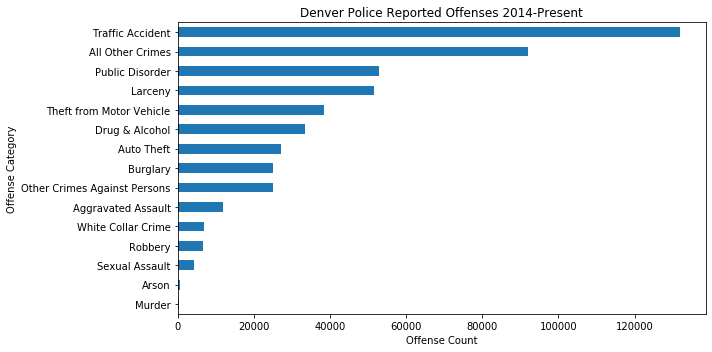

In [21]:
plt.figure(figsize=(10,5))
df.OFFENSE_CATEGORY_NAME.value_counts().plot(kind='barh', legend=False)
plt.ylabel('Offense Category')
plt.xlabel('Offense Count')
plt.title('Denver Police Reported Offenses 2014-Present')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

- Traffic Accidents are by and large the primary offense reported
- All Other Crimes (an aggregation of many other not as clearly defined offense types) has an immense number of counts - perhaps these could be better categorized?
- Looks like non-violent crime offenses (larceny, theft, burglary, etc.) are much more common than violent crime offenses (aggravated assault, robbery, sexual assault, murder)
- What exactly is public disorder - what types of offenses are these?
- What does just violent crime look like?

#### Traffic Accidents - should they be included?
Traffic accidents in and of themselves are not a crime, but it can be observed that accidents are reported more than any category/type of crime. For the purposes of this report and for further data analysis, traffic accident data will not be included. But the data can be analyzed in order to gain some quick knowledge.

In [22]:
t_df = df[df.OFFENSE_CATEGORY_NAME == 'Traffic Accident']

In [23]:
len(t_df[t_df.IS_CRIME == True])

0

Traffic accidents themselves are never crimes as the above value states.

In [24]:
hit_run_per = len(t_df[t_df.OFFENSE_TYPE_NAME == 'Traffic accident - hit and run']) / len(t_df)

In [25]:
print('Out of all the traffic accidents reported to police, {}% are hit and runs.'.format(round(hit_run_per*100, ndigits=2)))

Out of all the traffic accidents reported to police, 27.18% are hit and runs.


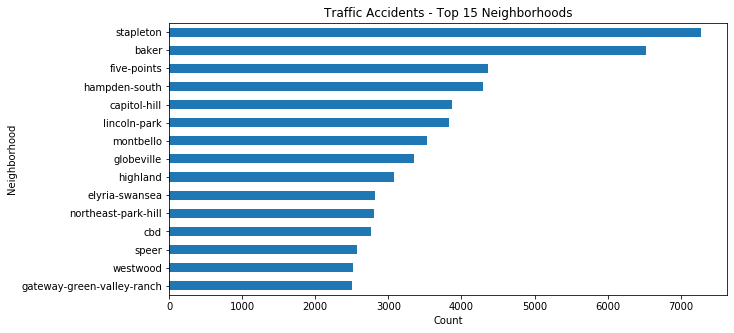

In [26]:
plt.figure(figsize=(10,5))
t_df.NEIGHBORHOOD_ID.value_counts().nlargest(15).plot.barh()
plt.title('Traffic Accidents - Top 15 Neighborhoods')
plt.xlabel('Count')
plt.ylabel('Neighborhood')
plt.gca().invert_yaxis()
plt.show()

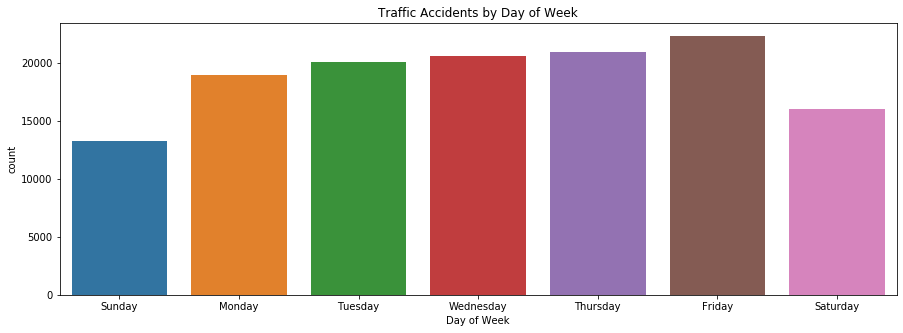

In [27]:
plt.figure(figsize=(15,5))
sns.countplot(data=t_df, x='FIRST_OCCURRENCE_DATE_DOW_N')
plt.title('Traffic Accidents by Day of Week')
plt.xlabel('Day of Week')
plt.show()

Unsurprisingly, Saturday and Sunday have the least number of accidents reported. It appears the number of accidents reported for the workweek actually increases slightly as the week goes on.

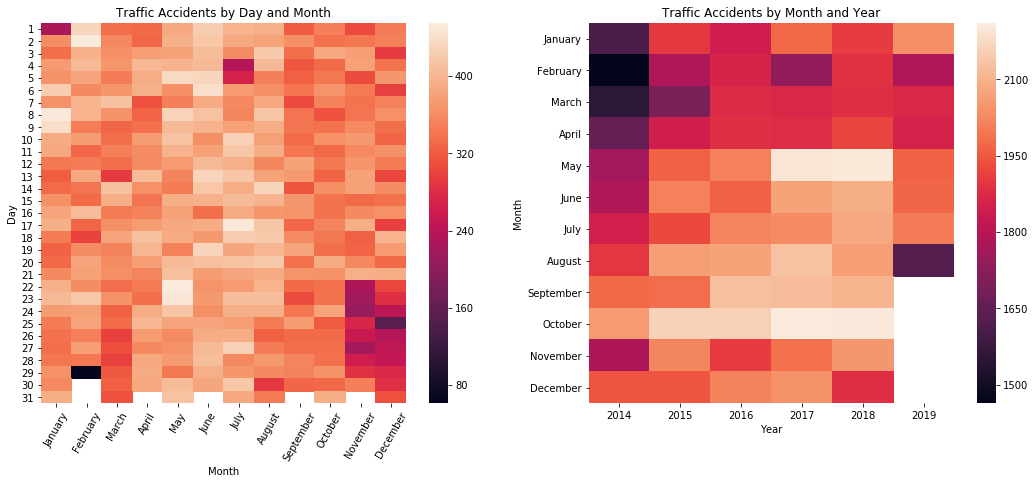

In [28]:
p_d_m = t_df.pivot_table('OFFENSE_ID', 'FIRST_OCCURRENCE_DATE_D', 'FIRST_OCCURRENCE_DATE_M_N', aggfunc='count')
p_m_y = t_df.pivot_table('OFFENSE_ID', 'FIRST_OCCURRENCE_DATE_M_N', 'FIRST_OCCURRENCE_DATE_Y', aggfunc='count')

plt.figure(figsize=(18,7))

plt.subplot(121)
ax = sns.heatmap(p_d_m)
ax.set_ylim(31, 0)
plt.xticks(rotation=60)
plt.ylabel('Day')
plt.xlabel('Month')
plt.title('Traffic Accidents by Day and Month')

plt.subplot(122)
ax = sns.heatmap(p_m_y)
ax.set_ylim(12, 0)
plt.ylabel('Month')
plt.xlabel('Year')
plt.title('Traffic Accidents by Month and Year')

plt.show()

- Contrary to what may be thought, July 4th and 5th actually have many less accidents reported than the apparent norm, this is likely because it is a federal holiday and fewer people are out driving during the day (I do wonder if the evening hours have a higher rate than average)
- Similarly, Thanksgiving week, Christmas week, and New Year's Day have an immense negative effect on the amount of accidents reported (likely because less people are driving on the roads)

*Note: Jan 1, 2014 is not included in this data, and as you can see from the chart on the right, the data may not be complete for the current year (meaning the current month and day less thirty have yet to be represented above)*

#### What's the deal with All Other Crimes?

In [29]:
aoc = df[df.OFFENSE_CATEGORY_NAME == 'All Other Crimes']

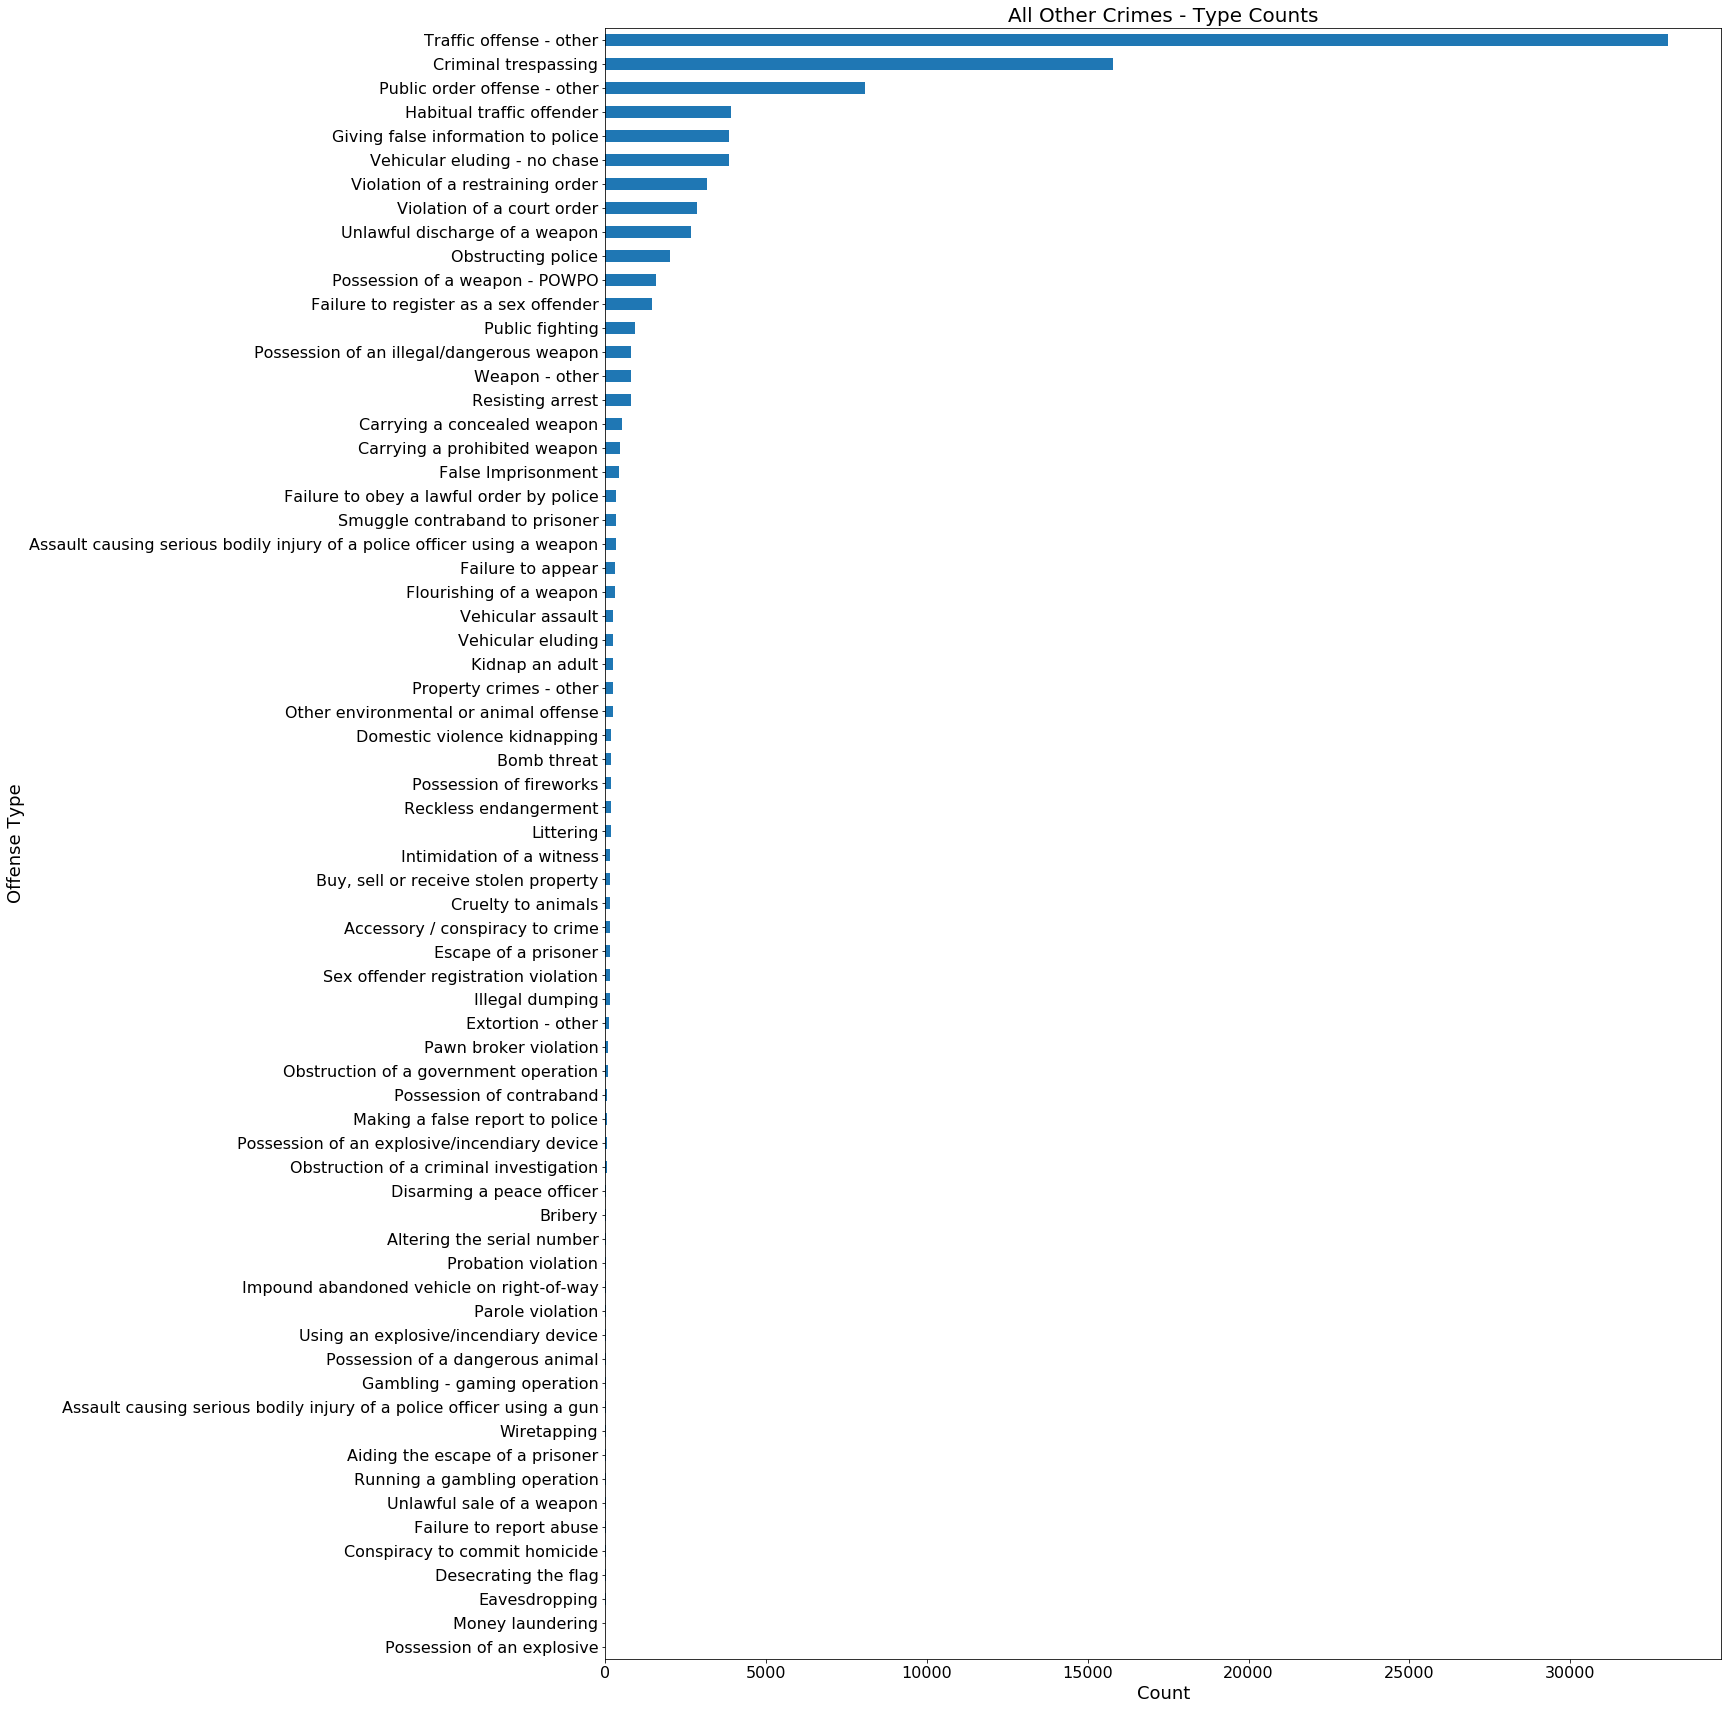

In [30]:
plt.figure(figsize=(20,30))
ax = aoc.OFFENSE_TYPE_NAME.value_counts().plot.barh()
plt.title('All Other Crimes - Type Counts', fontsize=20)
plt.ylabel('Offense Type', fontsize=18)
plt.xlabel('Count', fontsize=18)
ax.tick_params(axis='both', which='both', labelsize=16)
plt.gca().invert_yaxis()
plt.show()

In [31]:
i = aoc.OFFENSE_TYPE_NAME.value_counts()[0]
count = 0
for val in aoc.OFFENSE_TYPE_NAME.value_counts().values[1:]:
    while i > 0:
        i -= val
        count+=1

In [32]:
traf_per = aoc.OFFENSE_TYPE_NAME.value_counts()[0] / aoc.OFFENSE_TYPE_NAME.value_counts().sum()

In [33]:
print('- From the above, it can be observed that there are {} different types of crime in this one category!'.format(len(aoc.OFFENSE_TYPE_NAME.unique())))
print('- "Traffic offense - other" has more occurrences than the next {} types combined!'.format(count))
print('- "Traffic offense - other" also takes up a whopping {}% of this entire category'.format(round(traf_per*100, ndigits=2)))

- From the above, it can be observed that there are 68 different types of crime in this one category!
- "Traffic offense - other" has more occurrences than the next 3 types combined!
- "Traffic offense - other" also takes up a whopping 35.88% of this entire category


In [34]:
len(aoc[(aoc.OFFENSE_TYPE_NAME == 'Traffic offense - other') & (aoc.IS_CRIME == False)])

0

Once again, traffic leads the way. However, these traffic offenses are criminal, from the data provided there is no further specification for what type of traffic offenses are being committed, but there are still a large number of them.

Perhaps Denver needs to consider reorganizing/recategorizing many of the offenses that take place in this category as it is bloated and some of the types are similar to one another.

#### Public Disorder - another high volume crime category

In [35]:
pdis = df[df.OFFENSE_CATEGORY_NAME == 'Public Disorder']

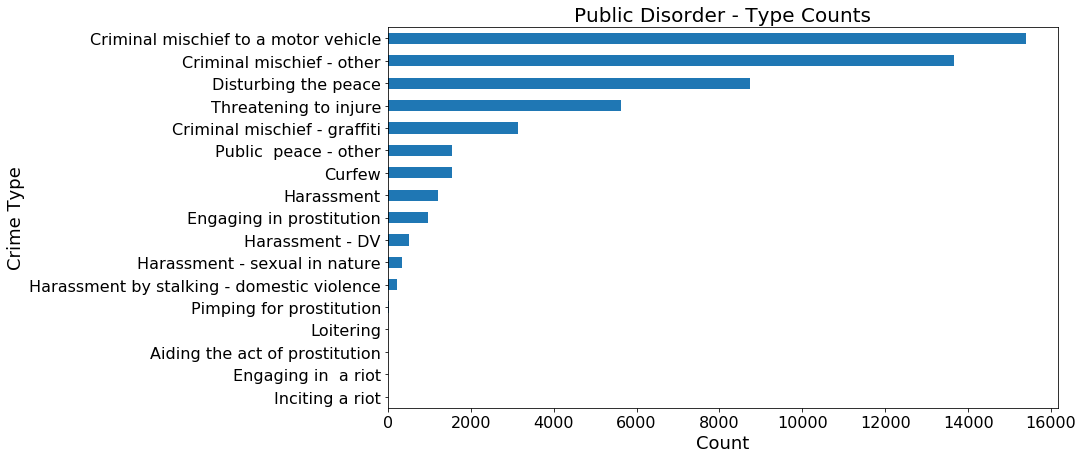

In [36]:
plt.figure(figsize=(12, 7))
ax = pdis.OFFENSE_TYPE_NAME.value_counts().plot.barh()
ax.tick_params(axis='both', which='both', labelsize=16)
plt.title('Public Disorder - Type Counts', fontsize=20)
plt.ylabel('Crime Type', fontsize=18)
plt.xlabel('Count', fontsize=18)
plt.gca().invert_yaxis()

plt.show()

Once again, the highest occurrence type has to do with vehicles. This category is primarily concerned with vandalism, criminal mischief, and what may be considered "crimes against society".

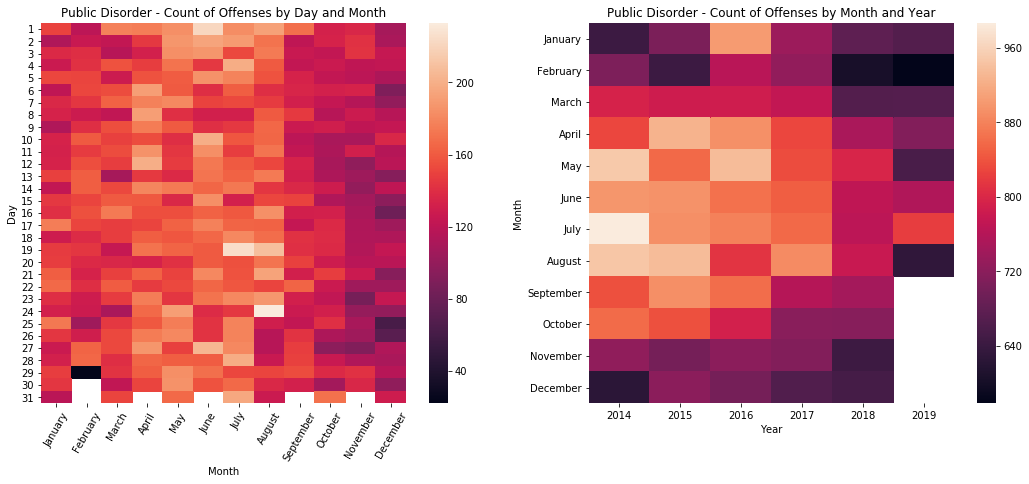

In [37]:
pdis_D_M = pdis.pivot_table('OFFENSE_ID', 'FIRST_OCCURRENCE_DATE_D', 'FIRST_OCCURRENCE_DATE_M_N', aggfunc='count')
pdis_M_Y = pdis.pivot_table('OFFENSE_ID', 'FIRST_OCCURRENCE_DATE_M_N', 'FIRST_OCCURRENCE_DATE_Y' , aggfunc='count')

plt.figure(figsize=(18,7))

plt.subplot(121)
ax = sns.heatmap(pdis_D_M)
ax.set_ylim(31, 0)
plt.xticks(rotation=60)
plt.title('Public Disorder - Count of Offenses by Day and Month')
plt.xlabel('Month')
plt.ylabel('Day')

plt.subplot(122)
ax = sns.heatmap(pdis_M_Y)
ax.set_ylim(12, 0)
plt.title('Public Disorder - Count of Offenses by Month and Year')
plt.xlabel('Year')
plt.ylabel('Month')

plt.show()

- Crimes in the Public Disorder category appear to be less likely to occur in winter months
- Why does January 2016 stray so far from the norm?

#### Violent crime - what is it and what are its general characteristics?
In the FBI’s Uniform Crime Reporting (UCR) Program, violent crime is composed of four offenses:  murder and nonnegligent manslaughter, forcible rape, robbery, and aggravated assault. Violent crimes are defined in the UCR Program as those offenses which involve force or threat of force. [[source]](https://ucr.fbi.gov/crime-in-the-u.s/2010/crime-in-the-u.s.-2010/violent-crime)

Based on the above definition it is easy to assemble a dataframe consisting of only violent crime offenses.

In [38]:
murder = df[df.OFFENSE_CATEGORY_NAME == 'Murder']
rape = df[df.OFFENSE_CATEGORY_NAME == 'Sexual Assault']
robbery = df[df.OFFENSE_CATEGORY_NAME == 'Robbery']
assault = df[df.OFFENSE_CATEGORY_NAME == 'Aggravated Assault']
v_df = pd.concat([murder, rape, robbery, assault])

Create some pivot tables containing time related data.

In [39]:
v_month = v_df.pivot_table('OFFENSE_ID', 'FIRST_OCCURRENCE_DATE_M_N', 'OFFENSE_CATEGORY_NAME', aggfunc='count')
v_dow = v_df.pivot_table('OFFENSE_ID', 'FIRST_OCCURRENCE_DATE_DOW_N', 'OFFENSE_CATEGORY_NAME', aggfunc='count')
v_year = v_df.pivot_table('OFFENSE_ID', 'FIRST_OCCURRENCE_DATE_Y', 'OFFENSE_CATEGORY_NAME', aggfunc='count')

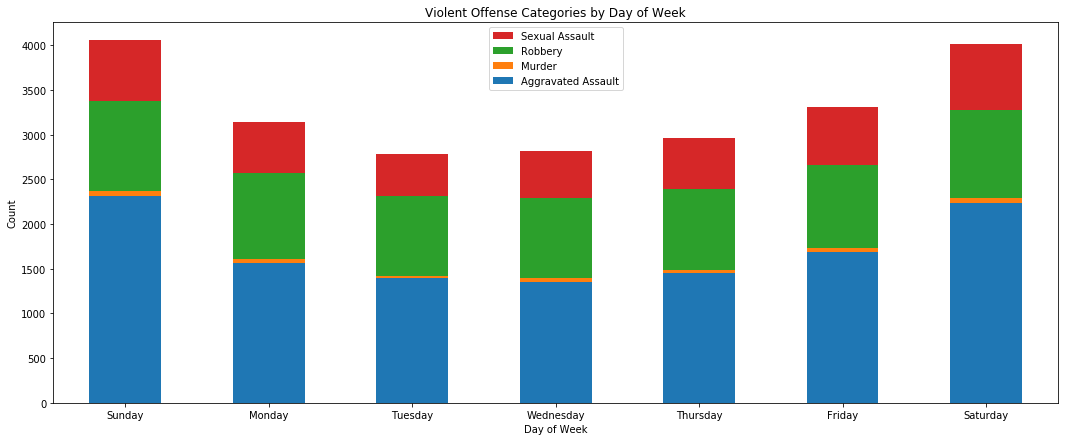

In [40]:
ax = v_dow.plot(kind='bar', figsize=(18,7), stacked=True)
plt.title('Violent Offense Categories by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(rotation=0)
handles, labels = ax.get_legend_handles_labels()
handles = [handles[3], handles[2], handles[1], handles[0]]
labels = [labels[3], labels[2], labels[1], labels[0]]
ax.legend(handles, labels)
plt.show()

- Aggravated Assault has the biggest effect on violent crime changes throughout the week (much more likely on the weekends)
- Robbery remains relatively consistent throughout the week and also contributes a significant sum to the total
- Sexual Assault is less common that Aggravated Assault, but it appears to have a similar 'weekend more likely' relationship
- The murder count appears to be mostly negligible compared to the amount of other violent crimes

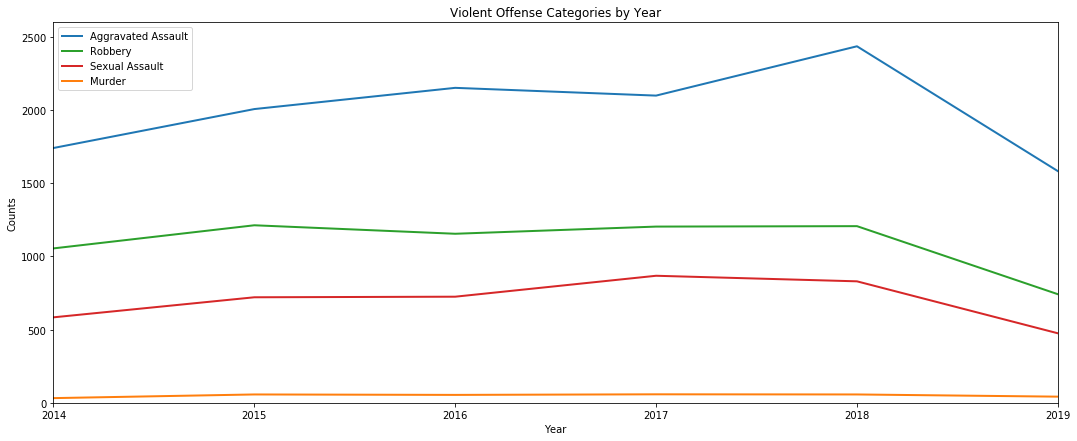

In [41]:
ax = v_year.plot(figsize=(18,7), linewidth=2)
plt.title('Violent Offense Categories by Year')
plt.ylabel('Counts')
plt.xlabel('Year')
plt.ylim(0,2600)
handles, labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[2], handles[3], handles[1]]
labels = [labels[0], labels[2], labels[3], labels[1]]
ax.legend(handles, labels)
plt.show()

- Appears the amount of violent crime per year is relatively steady (discounting 2019 as it is not yet complete)
- Aggravated Assault had a large uptick in 2018

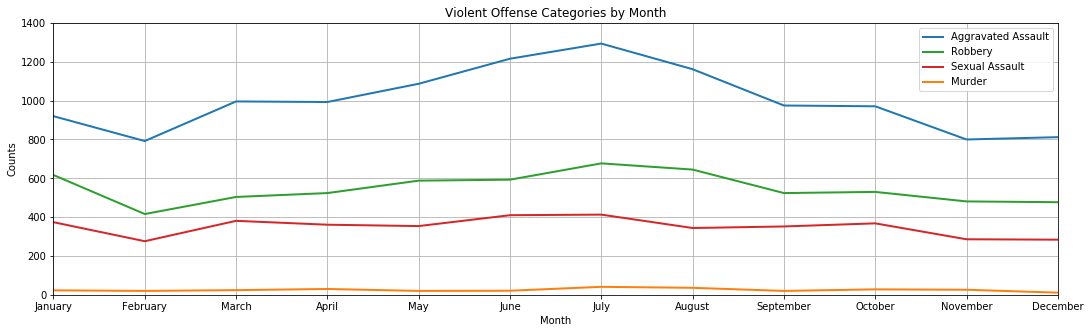

In [42]:
ax = v_month.plot(figsize=(18,5), linewidth=2)
plt.title('Violent Offense Categories by Month')
plt.ylabel('Counts')
plt.xlabel('Month')
plt.xticks(range(len(v_month.index)), v_month.index)
ax.xaxis.grid()
ax.yaxis.grid()
plt.ylim(0, 1400)
handles, labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[2], handles[3], handles[1]]
labels = [labels[0], labels[2], labels[3], labels[1]]
ax.legend(handles, labels)
plt.show()

For everything except Murder:
- Violent crime drops in February from January
- Slowly rises to its peak in July
- Starts to drop off beginning in August, decreasing through December
- Jumps back up in January again

#### A Closer Inspection of Murder

In [43]:
m_month = murder.pivot_table('OFFENSE_ID', 'FIRST_OCCURRENCE_DATE_M_N', 'OFFENSE_CATEGORY_NAME', aggfunc='count')
m_dow = murder.pivot_table('OFFENSE_ID', 'FIRST_OCCURRENCE_DATE_DOW_N', 'OFFENSE_CATEGORY_NAME', aggfunc='count')
m_year = murder.pivot_table('OFFENSE_ID', 'FIRST_OCCURRENCE_DATE_Y', 'OFFENSE_CATEGORY_NAME', aggfunc='count')

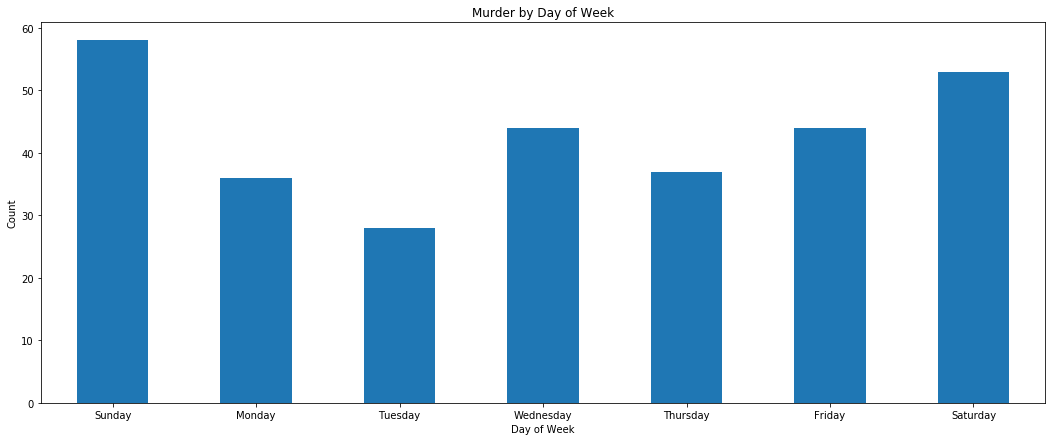

In [44]:
m_dow.plot(kind='bar', figsize=(18,7), legend=False)
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.xlabel('Day of Week')
plt.title('Murder by Day of Week')
plt.show()

- Murder has more cases on Saturday and Sunday, similar to Aggravated Assault and Sexual Assault
- Murder is also higher on Wednesday and Friday on the weekdays

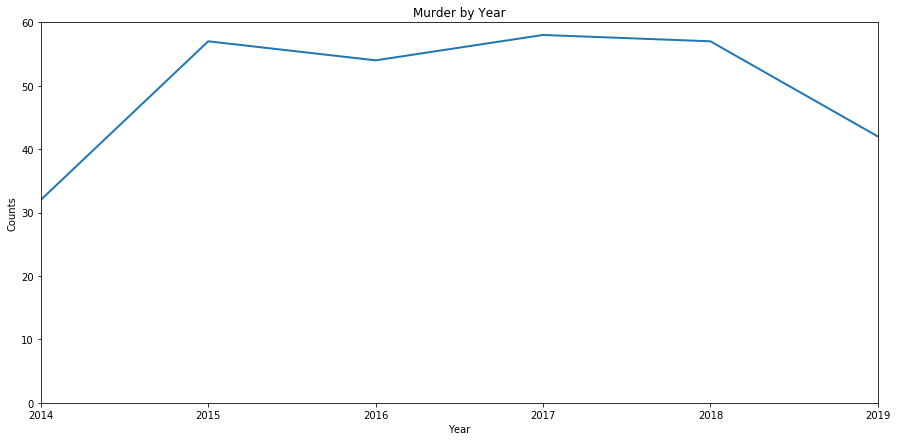

In [45]:
m_year.plot(figsize=(15,7), linewidth=2, legend=False)
plt.title('Murder by Year')
plt.ylabel('Counts')
plt.xlabel('Year')
plt.ylim(0,60)
plt.show()

- 2014 looks like an anomaly year compared to 2015-2018
- 2014 marked a year of large population growth for Denver [(1,566 people per month)](https://www.denverpost.com/2019/04/18/denver-population-growth-census/) which may explain why the murder rate pops up in 2015
- Will 2019 remain low?

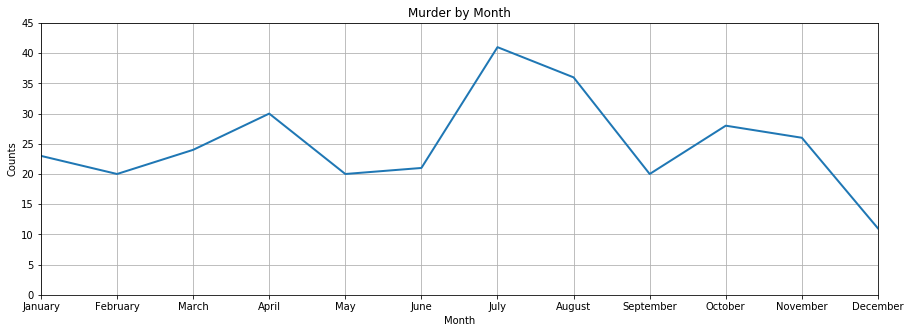

In [46]:
ax = m_month.plot(figsize=(15,5), linewidth=2, legend=False)
plt.title('Murder by Month')
plt.ylabel('Counts')
plt.xlabel('Month')
plt.xticks(range(len(m_month.index)), m_month.index)
plt.ylim(0,45)
ax.xaxis.grid()
ax.yaxis.grid()
plt.show()

- Murder is mostly consistent
- Above average number in July
- Relatively few cases in December

*Note: YTD is only included up to 30 days prior to the latest incident occurrence (some counts could be inflated/deflated)*

## Section 2: Analytic Questions
1. Does summer have an effect on the violent crime rate?
2. Which neighborhoods are the most dangerous? Are the top 10 most criminal neighborhoods really more dangerous than anywhere else?
3. Do certain types of crime have a report-delay?

### 1. Does summer have an effect on the violent crime rate?

The data used will be from `v_df`, which contains all the violent crimes over the past 5 years in Denver. To answer this question, the proper rate at which to compare summer to everything else needs to be considered. It could be possible to go by month, however summer is not constrained by a monthly parameter, it is constrained to particular days in a year. So likely the best way to separate and compare these two sets of data would be by days of year that occur in summer for a particular year (summer occurs in a different day of year range each year) against those days which occur outside the range of summer.

#### Step 1: Seperating `v_df` into two DataFrames - one with summer offenses and one without

First, determine need to find when summer actually occurred each year, this isn't too hard with a quick search on Google.

In [47]:
s2014_start = pd.to_datetime('June 21, 2014')
s2014_end = pd.to_datetime('September 22, 2014')
s2015_start = pd.to_datetime('June 21, 2015')
s2015_end = pd.to_datetime('September 23, 2015')
s2016_start = pd.to_datetime('June 20, 2016')
s2016_end = pd.to_datetime('September 22, 2016')
s2017_start = pd.to_datetime('June 20, 2017')
s2017_end = pd.to_datetime('September 22, 2017')
s2018_start = pd.to_datetime('June 21, 2018')
s2018_end = pd.to_datetime('September 22, 2018')
s2019_start = pd.to_datetime('June 21, 2019')
s2019_end = pd.to_datetime('September 23, 2019')

Filter `v_df` to get only summer offenses.

In [48]:
def f_occ():
    return v_df.FIRST_OCCURRENCE_DATE

Create a summer filter.

In [49]:
s2014 = ((s2014_start < f_occ()) & (f_occ() < s2014_end))
s2015 = ((s2015_start < f_occ()) & (f_occ() < s2015_end))
s2016 = ((s2016_start < f_occ()) & (f_occ() < s2016_end))
s2017 = ((s2017_start < f_occ()) & (f_occ() < s2017_end))
s2018 = ((s2018_start < f_occ()) & (f_occ() < s2018_end))
s2019 = ((s2019_start < f_occ()) & (f_occ() < s2019_end))
sfilt = s2014 | s2015 | s2016 | s2017 | s2018 | s2019

Use filter to create new summer violent crime dataframe, `s_v_df`.

In [50]:
s_v_df = v_df[sfilt]

Then to get the non-summer values the inverse of `sfilt` can be used.

In [51]:
ns_v_df = v_df[~sfilt]

The average violent crimes per day for both summer and non-summer need calculated.

In [52]:
sf_year = s_v_df.FIRST_OCCURRENCE_DATE.dt.year.rename('year')
sf_dayofyear = s_v_df.FIRST_OCCURRENCE_DATE.dt.dayofyear.rename('dayofyear')

In [53]:
s_counts = s_v_df.groupby([sf_year, sf_dayofyear]).count().INCIDENT_ID

In [54]:
md('`%f` is the average number of violent crimes per day in Denver during summer. The non-summer mean can be found similarly.'%(s_counts.mean()))

`12.593633` is the average number of violent crimes per day in Denver during summer. The non-summer mean can be found similarly.

In [55]:
nsf_year = ns_v_df.FIRST_OCCURRENCE_DATE.dt.year.rename('year')
nsf_dayofyear = ns_v_df.FIRST_OCCURRENCE_DATE.dt.dayofyear.rename('dayofyear')
ns_counts = ns_v_df.groupby([nsf_year, nsf_dayofyear]).count().INCIDENT_ID
ns_counts.mean()

10.686684073107049

#### Step 2: Checking Normality

In [56]:
s_mu, s_std = stats.norm.fit(s_counts)
ns_mu, ns_std = stats.norm.fit(ns_counts)

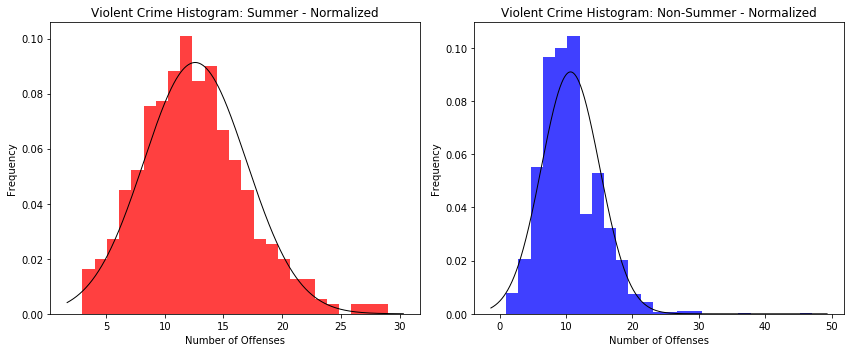

In [57]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(s_counts, bins=25, density=True, color='red', alpha=.75)
plt.title('Violent Crime Histogram: Summer - Normalized')
plt.ylabel('Frequency')
plt.xlabel('Number of Offenses')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, len(s_counts))
p = stats.norm.pdf(x, s_mu, s_std)
plt.plot(x, p, 'k', linewidth=1)
plt.subplot(122)
plt.title('Violent Crime Histogram: Non-Summer - Normalized')
plt.hist(ns_counts, bins=25, density=True, color='blue', alpha=.75)
plt.ylabel('Frequency')
plt.xlabel('Number of Offenses')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, len(ns_counts))
p = stats.norm.pdf(x, ns_mu, ns_std)
plt.plot(x, p, 'k', linewidth=1)

plt.tight_layout()
plt.show()

Based on a quick view of the histograms, it appears that both summer and non-summer crime are approximately normal. Probability plots are another good way to check.

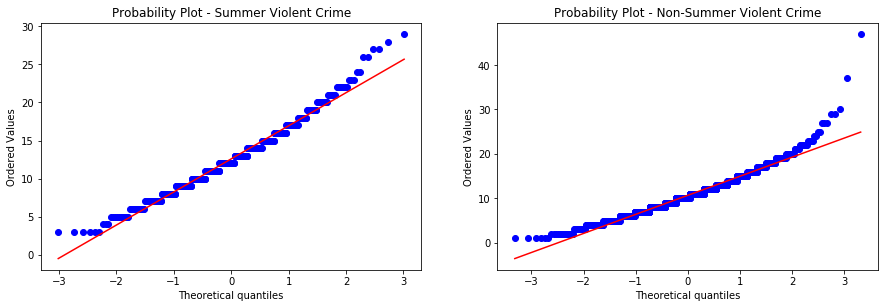

In [58]:
plt.figure(figsize=(15,10))

plt.subplot(221)
stats.probplot(s_counts, dist='norm', plot=plt)
plt.title('Probability Plot - Summer Violent Crime')

plt.subplot(222)
stats.probplot(ns_counts, dist='norm', plot=plt)
plt.title('Probability Plot - Non-Summer Violent Crime')

plt.show()

These look normally distributed to a point, the extremes or outliers seem to skew the data a bit, most of the data appears like-normal for both summer and non-summer datasets. Furthermore, the skew and kurtosis of the data can be examined.

In [59]:
print('Summer Skew: {} | Summer Kurtosis: {}'.format(s_counts.skew(), s_counts.kurt()))
print('Non-summer Skew: {} | Non-summer Kurtosis: {}'.format(ns_counts.skew(), ns_counts.kurt()))

Summer Skew: 0.525437078039316 | Summer Kurtosis: 0.6234119407412044
Non-summer Skew: 1.043740361723102 | Non-summer Kurtosis: 4.282145456619698


The summer data's skew is slightly positive, but still very close to zero, this indicates that the data trails off more in the positive direction than a normal distribution. The non-summer data's skew is similar, but almost double, which indicates that the outliers are more positively skewed (meaning there are either a few very large outliers or many small ones). The Kurtosis (rather "excess kurtosis" in this case) indicates that the tails of the distributions are 'heavy' or that more values fall within the relative tails compared to the normal distribution. These values in and of themselves aren't necessarily useful in determining how normal the data is, but rather describes in what ways it is not normal.

#### Step 3: The Tests
1. T-test in the case of normality
2. Mann-Whitney U Test in case the data is not normal

For both tests there must be a null hypothesis and an alternative hypothesis - which happen to be the same in this case.
- Null Hypothesis: Summer has no effect on the violent crime rate
- Alternative Hypothesis: Summer does have an effect on the violent crime rate

To test the null hypothesis the two populations `s_v_df` and `ns_v_df` must be compared, in other words the null hypothesis is asking if the sample `s_v_df` and `ns_v_df` come from the same population. If not, then the null hypothesis is rejected and the inference that summer has an effect on violent crime can be made.

In [60]:
t_stat, t_pval = stats.ttest_ind(s_counts, ns_counts, equal_var=False)
u_stat, u_pval = stats.mannwhitneyu(s_counts, ns_counts, alternative='two-sided')

In [61]:
md('The T-test statistic is %f with a p-value of %s'%(t_stat, str(t_pval)))

The T-test statistic is 8.668712 with a p-value of 1.9098644479213714e-17

In [62]:
md('The Mann-Whitney U statistic is %f with a p-value of %s'%(u_stat, str(u_pval)))

The Mann-Whitney U statistic is 515774.500000 with a p-value of 1.9625360542034607e-19

#### Conclusion: Does summer have an effect on the violent crime rate?

In short, yes. Summer absolutely has an effect on the violent crime rate in Denver, CO. This likely indicates that temperature may have a connection to violent crime as well since summer is generally the hottest season. 
- In the case that the data follows a like-normal distribution, the T-test rejects the null hypothesis that summer has no effect on the violent crime rate and instead supports the alternative that summer does have a significant effect on the crime rate in Denver.
- In the case that the data is not normal, the Mann-Whitney U Test also rejects the null hypothesis and supports the conclusion that summer does indeed have an effect on the violent crime rate in Denver.

### 2. Which neighborhoods are the most dangerous? Are the top 10 most criminal neighborhoods statistically more dangerous than anywhere else?

The first question can be answered quite easily, the most dangerous neighborhoods would be those with the most violent crime. So `v_df` can be used to quickly summarize the most dangerous neighborhoods. 

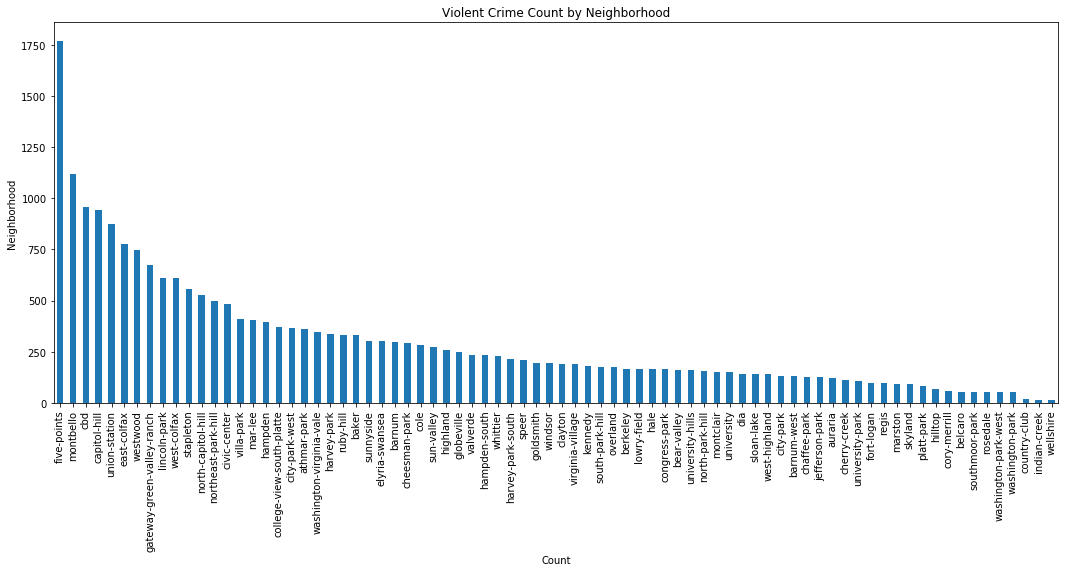

In [63]:
plt.figure(figsize=(18,7))
ax = v_df.NEIGHBORHOOD_ID.value_counts().plot.bar()
plt.title('Violent Crime Count by Neighborhood')
plt.ylabel('Neighborhood')
plt.xlabel('Count')
ax.tick_params(axis='both', which='both', labelsize=10)
plt.show()

- Five Points has a much higher violent crime rate than anywhere else
- There are some neighborhoods where violent crime is very rare (Country Club/Wellshire/Indian Creek)

#### Are the top 10 most criminal neighborhoods statistically more dangerous than anywhere else?
Similar to comparing summer to non-summer, the top 10 most criminal neighborhoods will be compared with the rest for days when crime occurs. First the two groups must be separated.

In [64]:
top10 = list(v_df.NEIGHBORHOOD_ID.value_counts().index[0:10])
bottom = list(v_df.NEIGHBORHOOD_ID.value_counts().index[10:])

top_df = pd.DataFrame()
for i in top10:
    top_df = top_df.append(v_df[v_df.NEIGHBORHOOD_ID == i])
    
bot_df = pd.DataFrame()
for i in bottom:
    bot_df = bot_df.append(v_df[v_df.NEIGHBORHOOD_ID == i])

Two dataframes `top_df` and `bot_df` have been created to represent the two populations. The average crime per day per neighborhood can now be calculated for these location groups.

In [65]:
top_year = top_df.FIRST_OCCURRENCE_DATE.dt.year.rename('year')
top_dayofyear = top_df.FIRST_OCCURRENCE_DATE.dt.dayofyear.rename('dayofyear')
top_counts = s_v_df.groupby(['NEIGHBORHOOD_ID', top_year, top_dayofyear]).count().OFFENSE_ID
bot_year = bot_df.FIRST_OCCURRENCE_DATE.dt.year.rename('year')
bot_dayofyear = bot_df.FIRST_OCCURRENCE_DATE.dt.dayofyear.rename('dayofyear')
bot_counts = bot_df.groupby(['NEIGHBORHOOD_ID', bot_year, bot_dayofyear]).count().OFFENSE_ID

In [66]:
top_counts.mean()

1.346579476861167

In [67]:
bot_counts.mean()

1.0959493274945262

#### Checking for Normality

In [68]:
top_mu, top_std = stats.norm.fit(top_counts)
bot_mu, bot_std = stats.norm.fit(bot_counts)

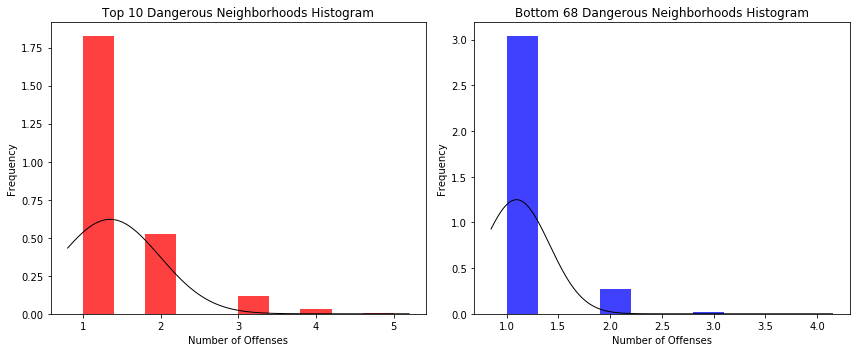

In [69]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(top_counts, bins=10, density=True, color='red', alpha=.75)
plt.title('Top 10 Dangerous Neighborhoods Histogram')
plt.ylabel('Frequency')
plt.xlabel('Number of Offenses')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, len(top_counts))
p = stats.norm.pdf(x, top_mu, top_std)
plt.plot(x, p, 'k', linewidth=1)
plt.subplot(122)
plt.title('Bottom 68 Dangerous Neighborhoods Histogram')
plt.hist(bot_counts, bins=10, density=True, color='blue', alpha=.75)
plt.ylabel('Frequency')
plt.xlabel('Number of Offenses')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, len(bot_counts))
p = stats.norm.pdf(x, bot_mu, bot_std)
plt.plot(x, p, 'k', linewidth=1)

plt.tight_layout()
plt.show()

Based on a quick view of the histograms, these two variables do not appear to be normal.

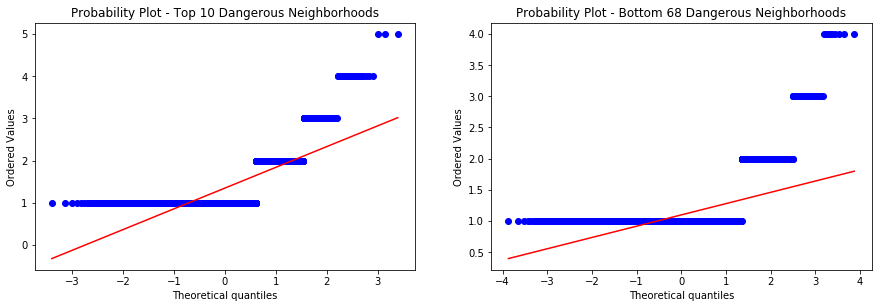

In [70]:
plt.figure(figsize=(15,10))

plt.subplot(221)
stats.probplot(top_counts, dist='norm', plot=plt)
plt.title('Probability Plot - Top 10 Dangerous Neighborhoods')

plt.subplot(222)
stats.probplot(bot_counts, dist='norm', plot=plt)
plt.title('Probability Plot - Bottom 68 Dangerous Neighborhoods')

plt.show()

These don't even look close to being normal. There is no point to check skew and kurtosis as they are going to be wildly away from 0.

#### Testing
- Use non-parametric Mann-Whitney U Test

There must be a null hypothesis and an alternative hypothesis:
- Null Hypothesis: The two sample groups `top_counts` and `bot_counts` come from the same population - top 10 dangerous neighborhoods are not significantly different than the rest of the neighborhoods
- Alternative Hypothesis: The aforementioned sample groups do not come from the same population - thus there is a significant difference between the top 10 neighborhoods' violent crime rate and the rest of the neighborhoods

To test the null hypothesis, the two populations `top_df` and `bot_df` must be compared.

In [71]:
u_stat, u_pval = stats.mannwhitneyu(top_counts, bot_counts, alternative='two-sided')

In [72]:
md('The Mann-Whitney U statistic is %f with a p-value of %s'%(u_stat, str(u_pval)))

The Mann-Whitney U statistic is 15062160.500000 with a p-value of 3.7818081811183524e-129

#### Conclusion: The Top 10 Neighborhoods are Significantly Different from the Rest

In [73]:
print('The Top 10 Dangerous Neighborhoods in Denver, CO are:')
count = 1
for i in top10:
    i = str(i).replace('-', ' ').title()
    print('{}. {}'.format(count, i))
    count += 1

The Top 10 Dangerous Neighborhoods in Denver, CO are:
1. Five Points
2. Montbello
3. Cbd
4. Capitol Hill
5. Union Station
6. East Colfax
7. Westwood
8. Gateway Green Valley Ranch
9. Lincoln Park
10. West Colfax


The top 10 dangerous neighborhoods are indeed significantly different than the rest, in this case that means that the violent crime rate in these neighborhoods is distinct and higher than the remaining neighborhoods.
- The Mann-Whitney U Test rejects the null hypothesis and supports the conclusion that the Top 10 Neighborhoods' crime rates are significantly different from the other 68 neighborhoods.

### 3. Are there certain types of crime that take a longer time to report?
For this question the main dataframe, `df`, will be used. The primary interest here is to see if any of the values under `OFFENSE_TYPE_NAME` tend to have a larger `DATE_DIFF` - the difference between when the incident occurred and when it was reported.

In [74]:
report_df = df.loc[:, ['OFFENSE_ID','OFFENSE_CATEGORY_NAME', 'OFFENSE_TYPE_NAME', 'DATE_DIFF']]

In [75]:
rep_type_df = pd.DataFrame()
rep_cat_df = pd.DataFrame()

In [76]:
for val in report_df.OFFENSE_TYPE_NAME.unique():
    rep_type_df.loc[val, 'DIFF_MEAN'] = report_df[report_df.OFFENSE_TYPE_NAME == val].DATE_DIFF.mean()
for val in report_df.OFFENSE_CATEGORY_NAME.unique():
    rep_cat_df.loc[val, 'DIFF_MEAN'] = report_df[report_df.OFFENSE_CATEGORY_NAME == val].DATE_DIFF.mean()

In [77]:
for i in rep_cat_df.index:
    rep_cat_df.loc[i, 'DIFF_MEAN'] = rep_cat_df.loc[i, 'DIFF_MEAN'].seconds/(3600) + rep_cat_df.loc[i, 'DIFF_MEAN'].days*24
for i in rep_type_df.index:
    rep_type_df.loc[i, 'DIFF_MEAN'] = rep_type_df.loc[i, 'DIFF_MEAN'].seconds/(3600) +rep_type_df.loc[i, 'DIFF_MEAN'].days*24

In [78]:
for i in rep_cat_df.index:
    rep_cat_df.loc[i, 'log_diff'] = np.log(rep_cat_df.loc[i, 'DIFF_MEAN'])

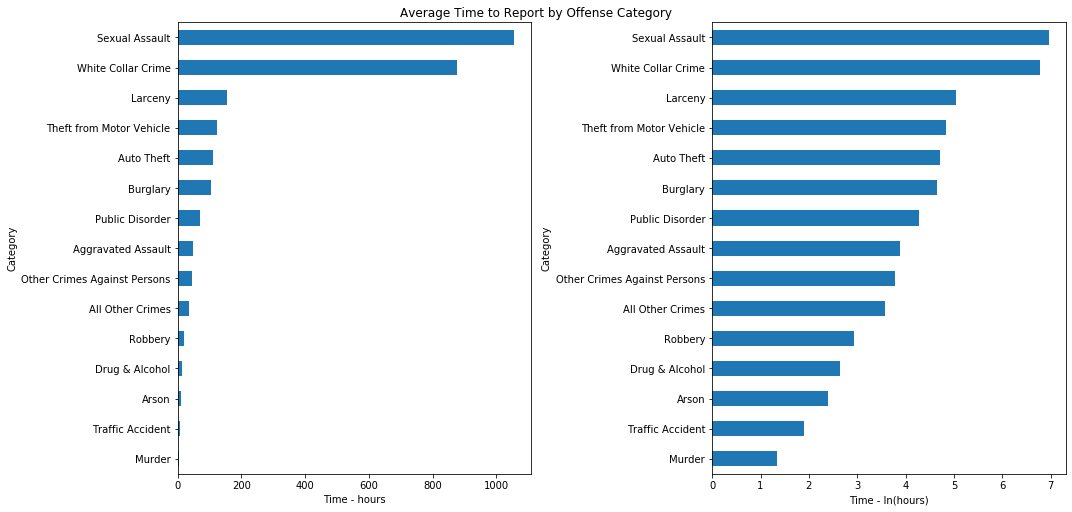

In [79]:
plt.figure(figsize=(15,7))
plt.suptitle('Average Time to Report by Offense Category', y=1.01)

plt.subplot(121)
rep_cat_df.DIFF_MEAN.sort_values().plot(kind='barh')
plt.ylabel('Category')
plt.xlabel('Time - hours')

plt.subplot(122)
rep_cat_df.log_diff.sort_values().plot(kind='barh')
plt.ylabel('Category')
plt.xlabel('Time - ln(hours)')

plt.tight_layout()
plt.show()

- It appears there are three groups of report lengths: very short (less than a day), short (between one day and one week), and long (a month or longer)
- The very short reports are Murder, Traffic Accident, Arson, Drug & Alcohol, and Robbery - this mostly makes sense as these categories of offenses are generally public or directly connected to individuals (perhaps with an exception of arson, which is a highly visible offense as fire is hard to miss)
- Murder is interesting, it is perhaps the most serious offense and is reported quickly, but should this be expected? Does this indicate that most murders are not hidden, but rather out there for people to stumble upon?
- From the short reports, it is interesting that aggravated assault and other crimes against persons take longer than a day to report on average, why is this? Have the victims/witnesses not had a chance to report? Are the victims/witnesses considering whether an offense should be reported - thus taking more time?
- Finally, white collar crime and sexual assault take a much longer time to report (averaging a month or greater)

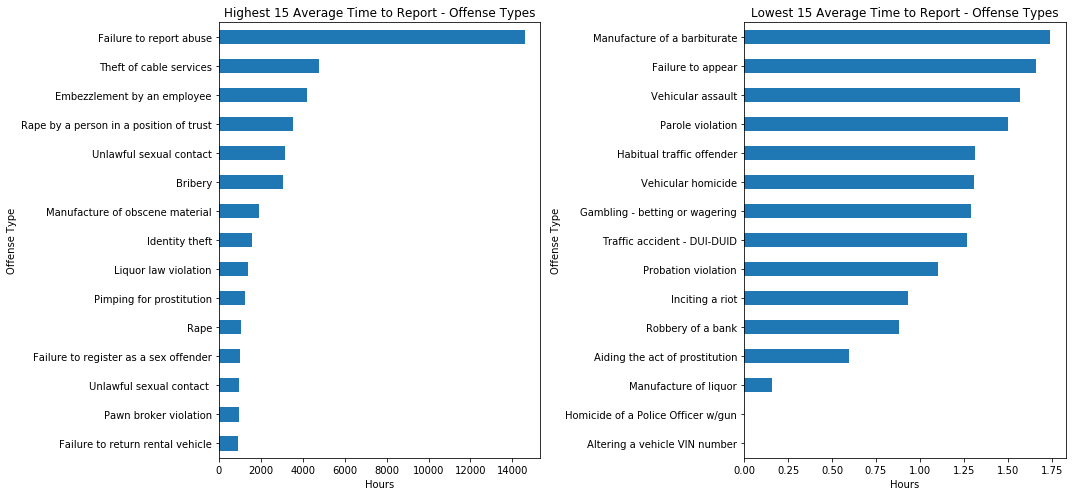

In [80]:
plt.figure(figsize=(15,7))

plt.subplot(121)
rep_type_df.DIFF_MEAN.sort_values().tail(15).plot.barh(title='Highest 15 Average Time to Report - Offense Types')
plt.xlabel('Hours')
plt.ylabel('Offense Type')

plt.subplot(122)
rep_type_df.DIFF_MEAN.sort_values().head(15).plot.barh(title='Lowest 15 Average Time to Report - Offense Types')
plt.xlabel('Hours')
plt.ylabel('Offense Type')

plt.tight_layout()
plt.show()

- It makes sense that failure to report abuse would be as high as it is - since the failure to report (or the difference between when the incident occurs and when it is reported) itself is dependent on how long it took for the incident to be reported
- Interestingly it looks like it took a long while for a certain party to notice their cable services were being stolen (only one instance of this in the entire dataset)
- A large number of the higher types are sexual in nature, why does it take so long to report these incidents?
- A number of the lowest average times are court/regulatory violations, drug violations and traffic related incidents
- Only a few types actually come in under the hour mark on average

#### Conclusion: Are there certain types of crime that take a longer time to report?
- It appears that certain categories of offenses do in fact take a longer time to report on average (Sexual Assault and White Collar Crime in particular)
- Also of note is that murder is reported in such a timely fashion, I do wonder if the `FIRST_OCCURRENCE_DATE` may be an indicator for when a body is found rather than when a murder is committed
- In the case of murder, the method would also be of interest, if the method is generally by firearm, then it would make sense why the report date would be so close to the occurrence date; other methods would likely take longer to detect
- It follows to group the offense categories into 3 groups:
     1. Offenses that on average take less than 1 day to report
     2. Offenses that on average take 1 day to 1 week to report
     3. Offenses that on average take 1 month or longer to report

## Section 3: Further Research Opportunities

In addition to questions asked in the exploratory data analysis and questions answered in analytic questions, more questions and opportunities to explore and analyze come to mind.

### Can potential crime 'hot spots' be located based on various factors/features?
- In conjunction with location, time and potentially weather data can predictions be made on where and when the next crime may occur?

__Requirements/Methods (of myself and the data):__
1. Ability to form a model to predict crime locations
2. Accurate weather data
3. More data to form a model
4. Ability to work with locations in a model
5. Much more knowledge of the Machine Learning part of Data Science

### Do weather conditions have a stronger tie to crime/types of crime? (More than 'summer = more violent')
- Perhaps certain crimes occur more/less frequently under certain weather conditions?

__Requirements/Methods:__
1. A reliable weather dataset
2. Could tie into above prediction model (weather as a feature)
3. Better understanding of checking correlation between dependent variable and the many features that may tie into it

### Explore and analyze demographic and population data in conjunction with the crime dataset.
- Are there demographic/population features of the various neighborhoods that could help in understanding crime in particular areas - or in Denver as a whole?
- Perhaps compare Denver to other big cities in the United States and see how they compare and contrast?

__Requirements/Methods:__
1. Demographic/population data of Denver or individual neighborhoods in Denver
2. Crime data for other big cities
3. See how demographics and population play a role in crime
4. Again, could help feed into predictive model above